In [1]:
import pathlib
from pathlib import Path

In [2]:
base_path = '/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture'
seg_path = Path('/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/data/segmentations')
train_images_path = Path('/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/data/train_images')
test_images_path = Path('/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/data/test_images')

In [3]:
# gather subject list and path
seg_files = list(seg_path.glob('*.nii'))
rsna_fracture_subjects = [ s.stem for s in seg_files]

train_subdirs = [f for f in train_images_path.iterdir() if f.is_dir()]
test_subdirs = [f for f in test_images_path.iterdir() if f.is_dir()]
train_subjects = [f.name for f in train_subdirs]
test_subjects = [f.name for f in test_subdirs]
print(len(train_subdirs),len(test_subdirs))

2019 3


In [4]:
# create pairs of image segmentation pairs
img_seg_pair = []
for subject, path in zip(rsna_fracture_subjects,seg_files):
    try:
        img_id = train_subjects.index(subject)
    except ValueError as e:
        print(f'could not find {subject}')
    img_seg_pair.append((subject,train_subdirs[img_id],path))


In [5]:
# write paths to file
with open('subject_list.csv','w') as f:
    f.write(f'id,subject,img_path,seg_path\n') # write header
    for i,(subject,img_path,seg_path) in enumerate(img_seg_pair):
        f.write(f'rsna-{i:02d},{subject},{img_path},{seg_path}\n')
# write subject list to file
with open('rsna_cervical.list','w') as f:
    for i,_ in enumerate(img_seg_pair):
        f.write(f'rsna-{i:02d}\n')

In [7]:
import SimpleITK as sitk
import numpy as np
def read_dicom(dicom_dir_path)->sitk.Image:
    if isinstance(dicom_dir_path,Path):
        dicom_dir_path = str(dicom_dir_path)
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(dicom_dir_path)
    reader.SetFileNames(dicom_names)

    image = reader.Execute()
    return image

def read_image(image_path)->sitk.Image:
    return sitk.ReadImage(image_path)
    
def save_image(img:sitk.Image,filename):
    sitk.WriteImage(img,fileName=filename)

def rsna_flip_mirror(img:sitk.Image,flip_axes)->sitk.Image:
    """flip in Z axis and mirror in X axis"""
    
    img_arr = sitk.GetArrayFromImage(img)
    flipped_img_arr = np.flip(img_arr, axis=flip_axes)
    flipped_img:sitk.Image = sitk.GetImageFromArray(flipped_img_arr)
    flipped_img.CopyInformation(img)
    return flipped_img

def get_metadata(img_path):
    reader = sitk.ImageFileReader()

    reader.SetFileName( img_path )
    reader.LoadPrivateTagsOn();

    reader.ReadImageInformation();
    return reader
    
def get_orientation(img:sitk.Image):
    return sitk.DICOMOrientImageFilter_GetOrientationFromDirectionCosines(img.GetDirection())

In [11]:
# create subjectwise directory
subjectwise_dir = Path(base_path)/'subjectwise'
subjectwise_dir.mkdir(exist_ok=True)

In [10]:
def get_stats(img:sitk.Image):
    fltr = sitk.LabelShapeStatisticsImageFilter()
    fltr.Execute(img)
    return fltr

In [ ]:
from tqdm import tqdm
for id, (subject,img_path, seg_path) in tqdm(enumerate(img_seg_pair)):
    ct = read_dicom(str(img_path))
    ct_axcode = sitk.DICOMOrientImageFilter_GetOrientationFromDirectionCosines(ct.GetDirection())
    ct_path = Path(subjectwise_dir)/f'rsna-{id:02d}'
    ct_path.mkdir(exist_ok=True)
    save_image(ct,str(ct_path/'ct.nii.gz'))

    seg = read_image(str(seg_path))
    seg = sitk.DICOMOrient(seg,ct_axcode)
    save_image(seg,str(ct_path/'seg.nii.gz'))
    print(ct_path)


In [18]:
# get voxel count
import pandas as pd
df = pd.read_csv('subject_list.csv')
subjectwise_dir = Path(base_path)/'subjectwise'

voxel_count = []
vertebra_count = []
nonborder_vertebra_count = []
for id,subject,img_path,seg_path in df.to_numpy():
    seg  = subjectwise_dir/id/'seg.nii.gz'

    stats = get_stats(sitk.ReadImage(str(seg)))
    voxel_count.append([stats.GetNumberOfPixelsOnBorder(l) for l in stats.GetLabels()])
    vertebra_count.append(len(stats.GetLabels()))
    nonborder_vertebra_count.append(np.sum([0 if stats.GetNumberOfPixelsOnBorder(l) > 0 else 1 for l in stats.GetLabels()]))


In [19]:
np.sum(vertebra_count),np.sum(nonborder_vertebra_count)

(922, 710)

In [20]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['lines.linewidth'] = 3
matplotlib.rcParams['lines.markersize'] = 10

In [21]:
from math import floor,log10
def format_func(value, tick_number=None):
    num_thousands = 0 if abs(value) < 1000 else floor (log10(abs(value))/3)
    value = round(value / 1000**num_thousands, 2)
    return f'{value:g}'+' KMGTPEZY'[num_thousands]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


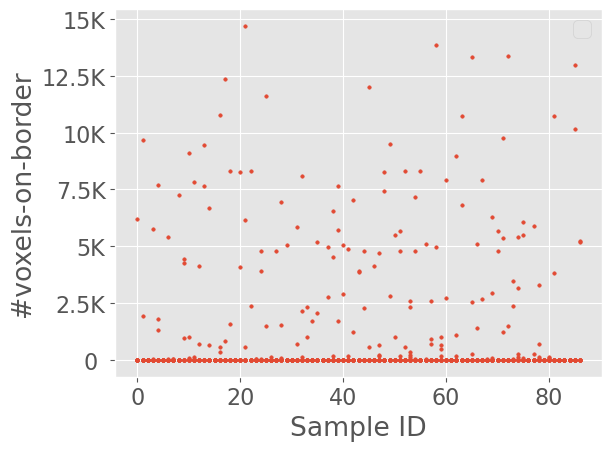

In [22]:
fig, ax = plt.subplots()
for id,v in enumerate(voxel_count):
    plt.scatter(x = (id,)*len(v),y=v,label='',s=6,c='#E24A33')
# plt.axhline(y=30000,linestyle='--',label='30k voxels',color='k')
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
plt.ylabel('#voxels-on-border')
plt.xlabel('Sample ID')
plt.legend()
plt.tight_layout()

In [23]:
# get voxel count
import pandas as pd
df = pd.read_csv('subject_list.csv')
subjectwise_dir = Path(base_path)/'subjectwise'

voxel_count = []
vertebra_count = []
nonborder_vertebra_count = []
for id,subject,img_path,seg_path in df.to_numpy():
    seg  = subjectwise_dir/id/'seg.nii.gz'

    stats = get_stats(sitk.ReadImage(str(seg)))
    voxel_count.append([stats.GetNumberOfPixelsOnBorder(l) for l in stats.GetLabels()])
    vertebra_count.append(len(stats.GetLabels()))
    nonborder_vertebra_count.append(([0 if stats.GetNumberOfPixelsOnBorder(l) > 0 else 1 for l in stats.GetLabels()]))


In [30]:
# nonborder_vertebra_count
vertebra_label = [f'C{i}' if i <=7 else f'T{i-7}' for i in range(1,14)]
vertebra_count_dict = { label:0 for label in vertebra_label}
for row in nonborder_vertebra_count:
    for exists,key in zip(row,vertebra_label):
        if exists:
            vertebra_count_dict[key] += 1
print(vertebra_count_dict)
# np.max([len(a) for a in nonborder_vertebra_count])

{'C1': 78, 'C2': 77, 'C3': 82, 'C4': 85, 'C5': 85, 'C6': 84, 'C7': 83, 'T1': 68, 'T2': 32, 'T3': 16, 'T4': 11, 'T5': 8, 'T6': 1}


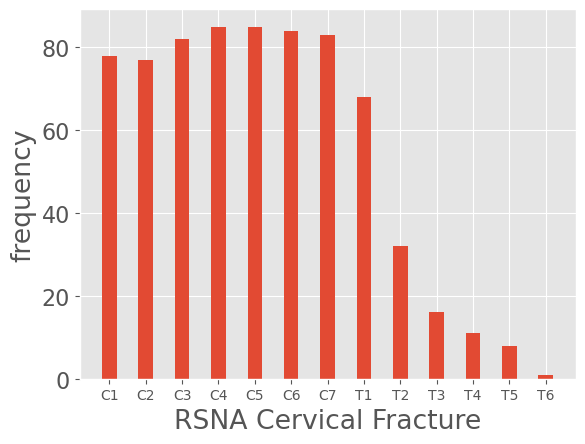

In [36]:
labels = list(vertebra_count_dict.keys())
count = list(vertebra_count_dict.values())
# creating the bar plot
plt.bar(labels, count, 
        width = 0.4)
plt.xlabel('RSNA Cervical Fracture')
plt.xticks(fontsize=10)
plt.ylabel('frequency')
plt.savefig('rsna_stats_plot.pdf')